In [1]:
import gym
import torch
import numpy as np
from ddpg_agent import Agent
import matplotlib.pyplot as plt

In [72]:
env = gym.make('BipedalWalker-v2')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = Agent(state_size=state_dim, action_size=action_dim, random_seed=0)

In [70]:
def ddpg(episodes, step, pretrained, noise):

    if pretrained:
#         agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location="cpu"))
#         agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location="cpu"))
#         agent.actor_target.load_state_dict(torch.load('checkpoint_actor_t.pth', map_location="cpu"))
#         agent.critic_target.load_state_dict(torch.load('checkpoint_critic_t.pth', map_location="cpu"))
        agent.actor_local.load_state_dict(torch.load('checkpoint_actor_pre.pth', map_location="cpu"))
        agent.critic_local.load_state_dict(torch.load('checkpoint_critic_pre.pth', map_location="cpu"))
        agent.actor_target.load_state_dict(torch.load('checkpoint_actor_t_pre.pth', map_location="cpu"))
        agent.critic_target.load_state_dict(torch.load('checkpoint_critic_t_pre.pth', map_location="cpu"))


    t_saves = np.linspace(0, episodes, 5 - 1, endpoint=False)
    reward_list = []
    rewards = []
    returns = []
    lengths = []
    losses  = []
    G = 0
    t_episode = 0
    counter = 0
    for i in range(episodes):

        state = env.reset()
        score = 0

        for t in range(step):

            action = agent.act(state, noise)
            next_state, reward, done, info = env.step(action[0])
            agent.step(state, action, reward, next_state, done)
            #state = next_state.squeeze()
            score += reward
            rewards.append(score)
            if done:
                state = env.reset()
                for r in rewards[::-1]:
                    G = 0.99*G + r
                returns.append(G)
                lengths.append(t_episode+1)
                this_episode = t_episode+1
                t_episode = 0
                G = 0
                rewards = []
                break
            else:
                state = next_state.squeeze()
                t_episode += 1

        reward_list.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tLength: {:.2f}'.format(i, np.mean(reward_list), score,this_episode), end="")
        if i % 20 == 0 and i!=0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth')
            np.save("reward_list",np.array(reward_list))
            np.save("returns",np.array(returns))
            np.save("lengths",np.array(lengths))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(reward_list)))   

        # save model
        if i in t_saves:
            model_name = f'{100 * i / episodes:04.1f}'.replace('.', '_')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor'+model_name+'.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic'+model_name+'.pth')
            torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t'+model_name+'.pth')
            torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t'+model_name+'.pth')
        
        if score >= 270:
            print('Task Solved')
            counter+=1
            if counter == 200:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                torch.save(agent.actor_target.state_dict(), 'checkpoint_actor_t.pth')
                torch.save(agent.critic_target.state_dict(), 'checkpoint_critic_t.pth') 
                break

    print('Training saved'
    return reward_list

In [73]:
scores = ddpg(episodes=100, step=2000, pretrained=1, noise=1)

#fig = plt.figure()
#plt.plot(np.arange(1, len(scores) + 1), scores)
#plt.ylabel('Score')
#plt.xlabel('Episode #')
#plt.show()

Episode 20	Average Score: -96.99	Score: -96.99	Length: 106.0000
Episode 40	Average Score: -121.09Score: -121.09	Length: 73.000
Episode 60	Average Score: -106.42Score: -106.42	Length: 112.00
Episode 80	Average Score: -81.47	Score: -81.47	Length: 318.000
Episode 99	Average Score: -96.86	Score: -120.82	Length: 76.000Training saved


In [13]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location="cpu"))

<All keys matched successfully>

In [2]:
rewards_ = np.load("Final Weights\\reward_list.npy")
returns_ = np.load("Final Weights\\returns.npy")
lengths_ = np.load("Final Weights\\lengths.npy")

In [8]:
def rolling_average(data, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [25]:
lenghts_rolling = rolling_average(lengths_,50)
rewards_rolling = rolling_average(rewards_,50)
returns_rolling = rolling_average(returns_,50)

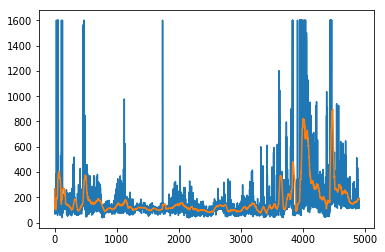

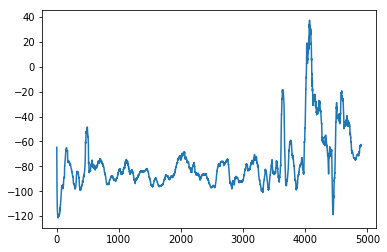

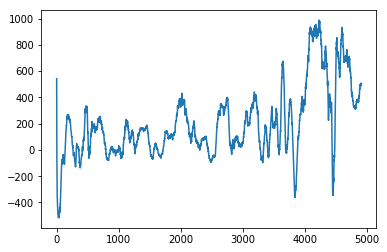

In [26]:
plt.plot(lengths_)
plt.plot(lenghts_rolling)
plt.show()
plt.plot(rewards_rolling)
plt.show()
plt.plot(returns_rolling)
plt.show()